Elemento 0 Problema  0
Elemento 1 Problema  0
Elemento 2 Problema  0
Elemento 3 Problema  0
Elemento 4 Problema  0
Elemento 5 Problema  0
Elemento 6 Problema  0
Elemento 7 Problema  0
Elemento 8 Problema  0
Elemento 9 Problema  0
Elemento 10 Problema  0
Elemento 11 Problema  0
Elemento 12 Problema  0
Elemento 13 Problema  0
Elemento 14 Problema  0
Elemento 15 Problema  0
Elemento 16 Problema  0
Elemento 17 Problema  0
Elemento 18 Problema  0
Elemento 19 Problema  0
Elemento 20 Problema  0
Elemento 21 Problema  0
Elemento 22 Problema  0
Elemento 23 Problema  0
Elemento 24 Problema  0
Elemento 25 Problema  0
Elemento 26 Problema  0
Elemento 27 Problema  0
Elemento 28 Problema  0
Elemento 29 Problema  0
Elemento 30 Problema  0
Elemento 31 Problema  0
Elemento 32 Problema  0
Elemento 33 Problema  0
Elemento 34 Problema  0
Elemento 35 Problema  0
Elemento 36 Problema  0
Elemento 37 Problema  0
Elemento 38 Problema  0
Elemento 39 Problema  0
Elemento 40 Problema  0
Elemento 41 Problema  0
El

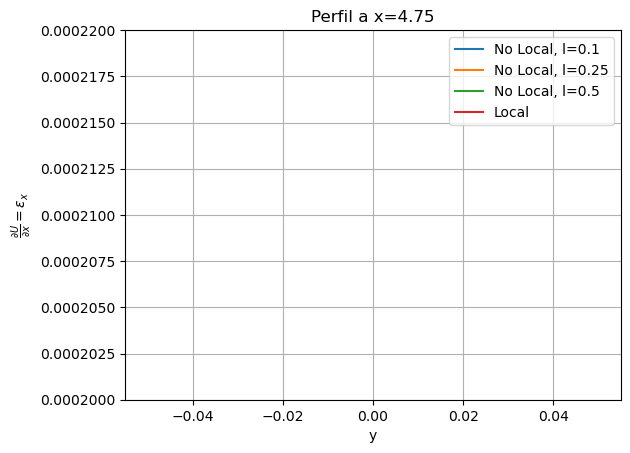

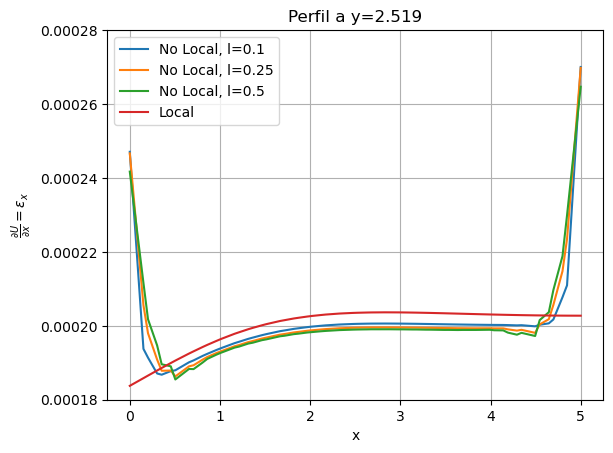

In [1]:
import NLFEM
import numpy as np
import matplotlib.pyplot as plt
from NLFEM.Mesh import Rect
import os
import copy
objetosFem = []
eles = [0.1,0.15,0.2]

def postProcesoX(this, U):
    this.Ue = U[np.ix_(this.gdl)]
    this._Ue = this.Ue.T[0].tolist()
    this._Ue.append(this.Ue[0][0])
    Z = this._dominioNaturalZ
    N = this._dominioNaturalN
    x = []
    y = []
    u = []
    this.U = lambda z, n: grad(this, z, n)[0]
    for z, n in zip(Z, N):
        x.append(this.Tx(z, n)[0])
        y.append(this.Ty(z, n)[0])
        u.append(this.U(z, n)[0])
    return x, y, u

def postProcesoXNodos(this, U):
    this.Ue = U[np.ix_(this.gdl)]
    this._Ue = this.Ue.T[0].tolist()
    this._Ue.append(this.Ue[0][0])
    Z = this.ZNatural
    N = this.NNatural
    u = []
    this.U = lambda z, n: grad(this, z, n)[0]
    for z, n in zip(Z, N):
        u.append(this.U(z, n)[0])
    return np.array(u).reshape([len(Z),1])

def postProcesoY(this, U):
    this.Ue = U[np.ix_(this.gdl)]
    this._Ue = this.Ue.T[0].tolist()
    this._Ue.append(this.Ue[0][0])
    Z = this._dominioNaturalZ
    N = this._dominioNaturalN
    x = []
    y = []
    u = []
    this.U = lambda z, n: grad(this, z, n)[1]
    for z, n in zip(Z, N):
        x.append(this.Tx(z, n)[0])
        y.append(this.Ty(z, n)[0])
        u.append(this.U(z, n)[0])
    return x, y, u

def grad(this, z, n):
    dz = this.dzpsis(z, n)
    dn = this.dnpsis(z, n)
    result = []
    for i in range(len(dz)):
        result.append(this._J(z, n) @ np.array([[dz[i][0]], [dn[i][0]]]))
    result = np.array(result)
    n = len(result)
    U = np.linspace(0,n-1,n).astype(int)
    V = U*2+1
    dx = (this.Ue[np.ix_(U)].T @ result[:, 0])[0]
    dy = (this.Ue[np.ix_(V)].T @ result[:, 1])[0]
    return np.array([dx, dy])
def defUnitariaX(this,figsize):
    count=0
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    markersize = 2
    cmap = 'magma'
    linewidth = 2
    xtotal = []
    ytotal = []
    ztotal = []
    count = 0
    for e in this.elementos:
        count+=1
        x,y,u = postProcesoX(e,this.U)
        xtotal.extend(x)
        ytotal.extend(y)
        ztotal.extend(u)
    surf = ax.plot_trisurf(xtotal, ytotal, ztotal,cmap=cmap,zorder=1)
    cbar = fig.colorbar(surf)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$\varepsilon x$')
    ax.set_title(r'$\frac{\partial U}{\partial X}$')
    return xtotal,ytotal,ztotal
def defUnitariaY(this,figsize):
    count=0
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    markersize = 2
    cmap = 'magma'
    linewidth = 2
    xtotal = []
    ytotal = []
    ztotal = []
    count = 0
    for e in this.elementos:
        count+=1
        x,y,u = postProcesoY(e,this.U)
        xtotal.extend(x)
        ytotal.extend(y)
        ztotal.extend(u)
    surf = ax.plot_trisurf(xtotal, ytotal, ztotal,cmap=cmap,zorder=1)
    cbar = fig.colorbar(surf)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$\varepsilon x$')
    ax.set_title(r'$\frac{\partial U}{\partial Y}$')

def darDeformacionXY(this, U, x, y, n=100):
    this.Ue = U[np.ix_(this.gdl)]
    this.U = lambda z, n: this.Ue.T[0] @ this.psis(z, n)
    zeta,eta = this.mappingInverso(x, y, n).reshape(1,2)[0].tolist()
    return this.U(zeta,eta)

PATH = os.getcwd()
nombre = "\\NLFEM\\Mesh\\input.txt"
GEOMETRIA = Rect.Rect(PATH+nombre,10,10)
GEOMETRIA.segmentos = [[0,60],[60,2820],[2820,2760],[2760,0]]
GEOMETRIA.cbe = []

def generarCBdesdeBordeX(this, borde, valor=0):
    cb = []
    nodos = this.darNodosCB(borde)
    cbe = np.zeros([len(nodos), 2])
    cbe[:, 0] = nodos*2
    cbe[:, 1] = valor
    cb += cbe.tolist()
    return cb

def generarCBdesdeBordeY(this, borde, valor=0):
    cb = []
    nodos = this.darNodosCB(borde)
    cbe = np.zeros([len(nodos), 2])
    cbe[:, 0] = nodos*2+1
    cbe[:, 1] = valor
    cb += cbe.tolist()
    return cb

def generarCBdesdeBorde(this, borde, valor=[0,0]):
    return generarCBdesdeBordeX(this, borde, valor[0])+generarCBdesdeBordeY(this, borde, valor[1])

a = 5
E = 2.1*10**6
V = 0.2
u = 0.001
for i in range(len(eles)):
    l = eles[i]
    RUTA_M = 'NLFEM_C++/NLFEM l '+format(l)+'/MATRICES'

    Objeto_FEM = NLFEM.NoLocal(GEOMETRIA)
    GEOMETRIA.cbe = generarCBdesdeBorde(GEOMETRIA,3,[0,0])+generarCBdesdeBordeX(GEOMETRIA,1,u)
    Objeto_FEM.definirCondicionesDeBorde(GEOMETRIA.cbe)
    Objeto_FEM.generarElementos()
    for i,e in enumerate(Objeto_FEM.elementos):
        n = len(e.coords)
        K = np.loadtxt(RUTA_M+'/Elemento'+format(i+1)+'/KL_'+format(i+1)+'.csv',delimiter=',').reshape([16,16])
        Q = np.zeros([2 * n, 1])
        F = np.zeros([2 * n, 1])
        e.determinarMatrices(K,F,Q)
        knls = []
        j=0
        print('Elemento', i, 'Problema ', len(objetosFem))
        for _ in e.elementosnl:
            j+=1
            KNL = np.loadtxt(RUTA_M+'/Elemento'+format(i+1)+'/KNL'+format(i+1)+'_'+format(j)+'.csv',delimiter=',').reshape([16,16])
            knls.append(KNL)
            e.KNLS = knls
    PUNTOS = [-np.sqrt(3.0/5.0),0,np.sqrt(3.0/5.0)]
    for this in Objeto_FEM.elementos:
        this._dominioNaturalZ = PUNTOS
        this._dominioNaturalN = PUNTOS
    z1=0.5
    Objeto_FEM.z1 = z1
    Objeto_FEM.K = np.zeros([Objeto_FEM.n,Objeto_FEM.n])
    Objeto_FEM.F = np.zeros([Objeto_FEM.n,1])
    Objeto_FEM.Q = np.zeros([Objeto_FEM.n,1])
    Objeto_FEM.U = np.zeros([Objeto_FEM.n,1])
    Objeto_FEM.S = np.zeros([Objeto_FEM.n,1])
    Objeto_FEM.definirCondicionesDeBorde(Objeto_FEM.geometria.cbe)
    Objeto_FEM.ensamblar()
    Objeto_FEM.condicionesFrontera(Objeto_FEM.cbe,Objeto_FEM.cbn)
    Objeto_FEM.solucionarSistemaEcuaciones()
    print('+++++++++++++++++++++++++++++',len(objetosFem))
    objetosFem.append(copy.deepcopy(Objeto_FEM))

Objeto_FEMLOCAL = copy.deepcopy(Objeto_FEM)
Objeto_FEMLOCAL.z1 = 1
Objeto_FEMLOCAL.K = np.zeros([Objeto_FEMLOCAL.n,Objeto_FEMLOCAL.n])
Objeto_FEMLOCAL.F = np.zeros([Objeto_FEMLOCAL.n,1])
Objeto_FEMLOCAL.Q = np.zeros([Objeto_FEMLOCAL.n,1])
Objeto_FEMLOCAL.U = np.zeros([Objeto_FEMLOCAL.n,1])
Objeto_FEMLOCAL.S = np.zeros([Objeto_FEMLOCAL.n,1])
Objeto_FEMLOCAL.definirCondicionesDeBorde(Objeto_FEMLOCAL.geometria.cbe)
Objeto_FEMLOCAL.ensamblar()
Objeto_FEMLOCAL.condicionesFrontera(Objeto_FEMLOCAL.cbe,Objeto_FEMLOCAL.cbn)
Objeto_FEMLOCAL.solucionarSistemaEcuaciones()
x=4.750
_Y = np.linspace(0,5,100).tolist()
Z = []
Y = []
Zl01 = []
Zl025 = []
Zl05 = []
Zlocal = []

for y in _Y:
    for i in range(len(Objeto_FEM.elementos)):
        el01 = objetosFem[0].elementos[i]
        el025 = objetosFem[1].elementos[i]
        el05 = objetosFem[2].elementos[i]
        elocal = Objeto_FEMLOCAL.elementos[i]
        if elocal.estaDentro(x,y):
            Y.append(y)

            U = postProcesoXNodos(el01,objetosFem[0].U)
            Zl01.append(el01.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el025,objetosFem[1].U)
            Zl025.append(el025.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el05,objetosFem[2].U)
            Zl05.append(el05.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(elocal,Objeto_FEMLOCAL.U)
            Zlocal.append(elocal.darSolucionXY(U, x, y, n=100))
            break
plt.plot(Y,Zl01)
plt.plot(Y,Zl025)
plt.plot(Y,Zl05)
plt.plot(Y,Zlocal)
print(Y)
plt.ylim(0.0002, 0.00022)

plt.grid()
plt.title('Perfil a x='+format(x))
plt.xlabel('y')
plt.ylabel(r'$\frac{\partial U}{\partial x}=\varepsilon_x$')
plt.legend(['No Local, l=0.1','No Local, l=0.25','No Local, l=0.5','Local'])
plt.savefig('deformacionesXvariandolEnX'+format(x)+'.svg')
plt.show()


y = 2.519
_X = np.linspace(0,5,100).tolist()
Z = []
X = []
Zl01 = []
Zl025 = []
Zl05 = []
Zlocal = []

for x in _X:
    for i in range(len(Objeto_FEM.elementos)):
        el01 = objetosFem[0].elementos[i]
        el025 = objetosFem[1].elementos[i]
        el05 = objetosFem[2].elementos[i]
        elocal = Objeto_FEMLOCAL.elementos[i]
        if el01.estaDentro(x,y):
            X.append(x)

            U = postProcesoXNodos(el01,objetosFem[0].U)
            Zl01.append(el01.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el025,objetosFem[1].U)
            Zl025.append(el025.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el05,objetosFem[2].U)
            Zl05.append(el05.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(elocal,Objeto_FEMLOCAL.U)
            Zlocal.append(elocal.darSolucionXY(U, x, y, n=100))
            break
plt.plot(X,Zl01)
plt.plot(X,Zl025)
plt.plot(X,Zl05)
plt.plot(X,Zlocal)
plt.ylim(0.00018, 0.00028)


plt.grid()
plt.title('Perfil a y='+format(y))
plt.xlabel('x')
plt.ylabel(r'$\frac{\partial U}{\partial x}=\varepsilon_x$')
plt.legend(['No Local, l=0.1','No Local, l=0.25','No Local, l=0.5','Local'])
plt.savefig('deformacionesXvariandolEnY'+format(y)+'.svg')
plt.show()


[]


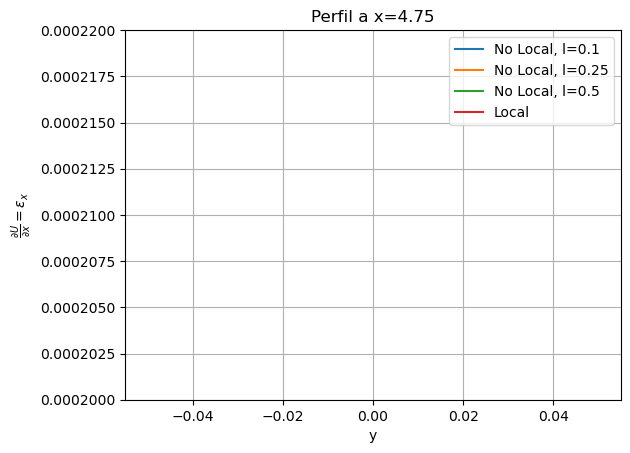

In [2]:
x=4.750
_Y = np.linspace(0,5,100).tolist()
Z = []
Y = []
Zl01 = []
Zl025 = []
Zl05 = []
Zlocal = []

for y in _Y:
    for i in range(len(Objeto_FEM.elementos)):
        el01 = objetosFem[0].elementos[i]
        el025 = objetosFem[1].elementos[i]
        el05 = objetosFem[2].elementos[i]
        elocal = Objeto_FEMLOCAL.elementos[i]
        if elocal.estaDentro(x,y):
            Y.append(y)

            U = postProcesoXNodos(el01,objetosFem[0].U)
            Zl01.append(el01.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el025,objetosFem[1].U)
            Zl025.append(el025.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el05,objetosFem[2].U)
            Zl05.append(el05.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(elocal,Objeto_FEMLOCAL.U)
            Zlocal.append(elocal.darSolucionXY(U, x, y, n=100))
            break
plt.plot(Y,Zl01)
plt.plot(Y,Zl025)
plt.plot(Y,Zl05)
plt.plot(Y,Zlocal)
print(Y)
plt.ylim(0.0002, 0.00022)

plt.grid()
plt.title('Perfil a x='+format(x))
plt.xlabel('y')
plt.ylabel(r'$\frac{\partial U}{\partial x}=\varepsilon_x$')
plt.legend(['No Local, l=0.1','No Local, l=0.25','No Local, l=0.5','Local'])
plt.savefig('deformacionesXvariandolEnX'+format(x)+'.svg')
plt.show()

[0.15151515151515152, 0.20202020202020202, 0.30303030303030304, 0.35353535353535354, 0.45454545454545453, 0.5050505050505051, 0.6565656565656566, 0.7070707070707071, 0.8080808080808081, 0.8585858585858586, 0.9595959595959596, 1.0101010101010102, 1.1616161616161615, 1.2121212121212122, 1.3131313131313131, 1.3636363636363635, 1.4646464646464645, 1.5151515151515151, 1.6666666666666667, 1.8181818181818181, 1.8686868686868687, 1.9696969696969697, 2.0202020202020203, 2.121212121212121, 2.1717171717171717, 2.323232323232323, 2.3737373737373737, 2.474747474747475, 2.525252525252525, 2.6262626262626263, 2.676767676767677, 2.8282828282828283, 2.878787878787879, 2.9797979797979797, 3.0303030303030303, 3.131313131313131, 3.1818181818181817, 3.3333333333333335, 3.484848484848485, 3.5353535353535355, 3.6363636363636362, 3.686868686868687, 3.7878787878787876, 3.8383838383838382, 3.9898989898989896, 4.040404040404041, 4.141414141414141, 4.191919191919192, 4.292929292929293, 4.343434343434343, 4.494949

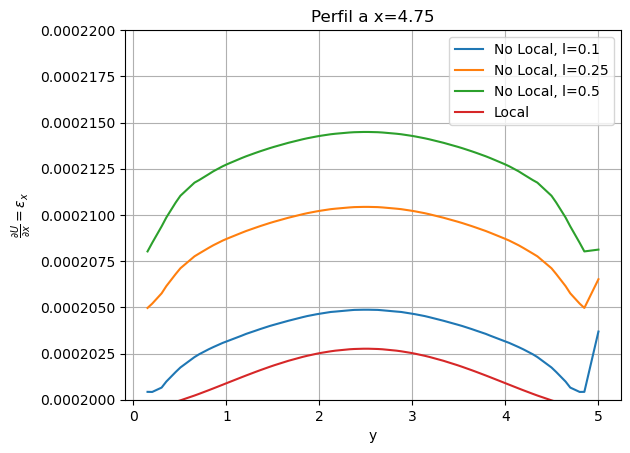

In [26]:
x=4.750
_Y = np.linspace(0,5,100).tolist()
Z = []
Y = []
Zl01 = []
Zl025 = []
Zl05 = []
Zlocal = []

for y in _Y:
    for i in range(len(Objeto_FEM.elementos)):
        el01 = objetosFem[0].elementos[i]
        el025 = objetosFem[1].elementos[i]
        el05 = objetosFem[2].elementos[i]
        elocal = Objeto_FEMLOCAL.elementos[i]
        if elocal.estaDentro(x,y):
            Y.append(y)

            U = postProcesoXNodos(el01,objetosFem[0].U)
            Zl01.append(el01.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el025,objetosFem[1].U)
            Zl025.append(el025.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(el05,objetosFem[2].U)
            Zl05.append(el05.darSolucionXY(U, x, y, n=100))

            U = postProcesoXNodos(elocal,Objeto_FEMLOCAL.U)
            Zlocal.append(elocal.darSolucionXY(U, x, y, n=100))
            break
plt.plot(Y,Zl01)
plt.plot(Y,Zl025)
plt.plot(Y,Zl05)
plt.plot(Y,Zlocal)
print(Y)
plt.ylim(0.0002, 0.00022)

plt.grid()
plt.title('Perfil a x='+format(x))
plt.xlabel('y')
plt.ylabel(r'$\frac{\partial U}{\partial x}=\varepsilon_x$')
plt.legend(['No Local, l=0.1','No Local, l=0.25','No Local, l=0.5','Local'])
plt.savefig('deformacionesXvariandolEnX'+format(x)+'.svg')
plt.show()

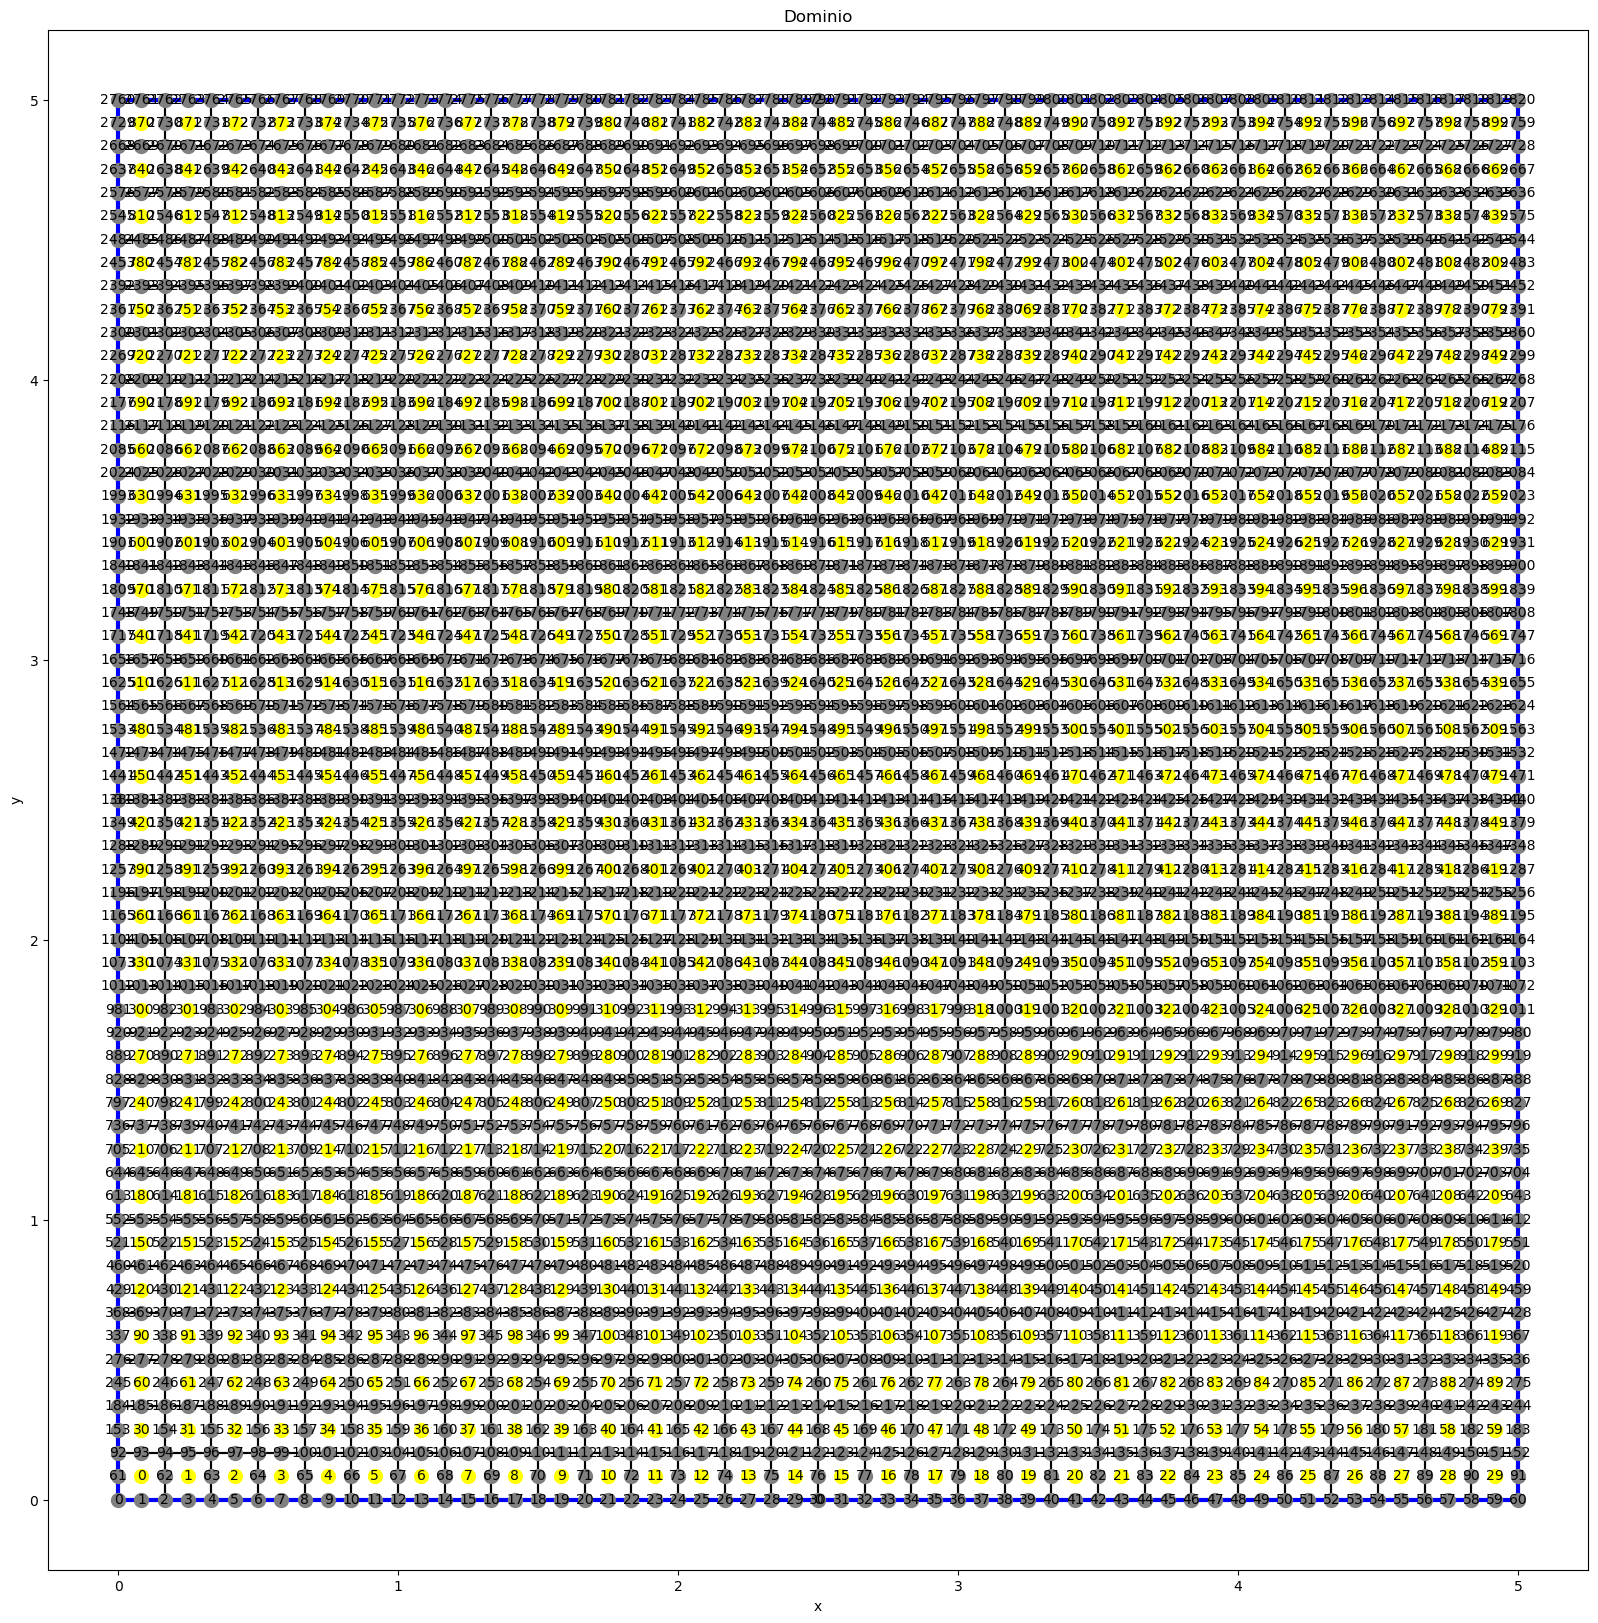

In [15]:
Objeto_FEMLOCAL.geometria.dibujarse(figsize=[20,20])

In [46]:
h=5/30
5-2*h

4.666666666666667

0.0
0.050505050505050504
0.10101010101010101
0.15151515151515152
0.20202020202020202
0.25252525252525254
0.30303030303030304
0.35353535353535354
0.40404040404040403
0.45454545454545453
0.5050505050505051
0.5555555555555556
0.6060606060606061
0.6565656565656566
0.7070707070707071
0.7575757575757576
0.8080808080808081
0.8585858585858586
0.9090909090909091
0.9595959595959596
1.0101010101010102
1.0606060606060606
1.1111111111111112
1.1616161616161615
1.2121212121212122
1.2626262626262625
1.3131313131313131
1.3636363636363635
1.4141414141414141
1.4646464646464645
1.5151515151515151
1.5656565656565655
1.6161616161616161
1.6666666666666667
1.7171717171717171
1.7676767676767677
1.8181818181818181
1.8686868686868687
1.9191919191919191
1.9696969696969697
2.0202020202020203
2.0707070707070705
2.121212121212121
2.1717171717171717
2.2222222222222223
2.2727272727272725
2.323232323232323
2.3737373737373737
2.4242424242424243
2.474747474747475
2.525252525252525
2.5757575757575757
2.6262626262626263
2.

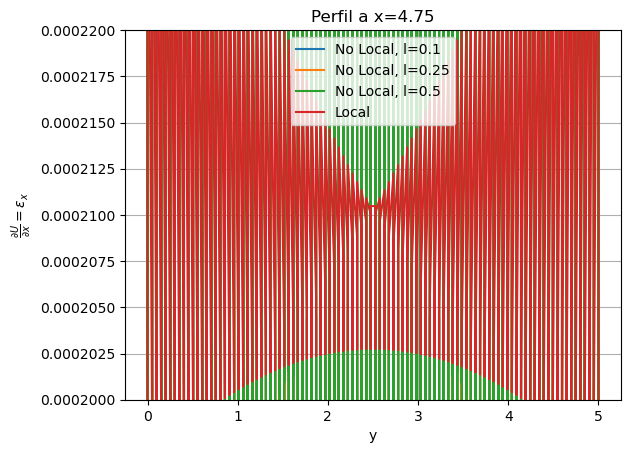

In [44]:
elementosPerfil = [28+i*30 for i in range(0,30)]
x=4.750
_Y = np.linspace(0,5,100).tolist()
Z = []
Y = []
Zl01 = []
Zl025 = []
Zl05 = []
Zlocal = []

for y in _Y:
    print(y)
    for i in elementosPerfil:
        el01 = objetosFem[0].elementos[i]
        el025 = objetosFem[1].elementos[i]
        el05 = objetosFem[2].elementos[i]
        elocal = Objeto_FEMLOCAL.elementos[i]
        Y.append(y)

        U = postProcesoXNodos(el01,objetosFem[0].U)
        Zl01.append(el01.darSolucionXY(U, x, y, n=100))

        U = postProcesoXNodos(el025,objetosFem[1].U)
        Zl025.append(el025.darSolucionXY(U, x, y, n=100))

        U = postProcesoXNodos(el05,objetosFem[2].U)
        Zl05.append(el05.darSolucionXY(U, x, y, n=100))

        U = postProcesoXNodos(elocal,Objeto_FEMLOCAL.U)
        Zlocal.append(elocal.darSolucionXY(U, x, y, n=100))
plt.plot(Y,Zl01)
plt.plot(Y,Zl025)
plt.plot(Y,Zl05)
plt.plot(Y,Zlocal)
print(Y)
plt.ylim(0.0002, 0.00022)

plt.grid()
plt.title('Perfil a x='+format(x))
plt.xlabel('y')
plt.ylabel(r'$\frac{\partial U}{\partial x}=\varepsilon_x$')
plt.legend(['No Local, l=0.1','No Local, l=0.25','No Local, l=0.5','Local'])
plt.savefig('deformacionesXvariandolEnX'+format(x)+'.svg')
plt.show()